In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
import numpy as np
import pandas as pd
import ast
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [6]:
csv_path = "yoga_keypoints_with_angles.csv"
df = pd.read_csv(csv_path)

In [7]:
keypoint_columns = df.columns[2:134]  
angle_columns = df.columns[134:142]  
label_column = 'class_label'

In [8]:
def parse_tuple(value):
    try:
        return list(ast.literal_eval(value)) 
    except:
        return [0, 0, 0, 0]  

for col in keypoint_columns:
    df[col] = df[col].apply(parse_tuple)

In [9]:
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df[label_column])

In [10]:
X = []
for i, row in df.iterrows():
    keypoints_flat = np.array([item for sublist in row[keypoint_columns] for item in sublist], dtype=np.float32)
    angles = np.array(row[angle_columns], dtype=np.float32)
    X.append(np.concatenate([keypoints_flat, angles]))
X = np.array(X, dtype=np.float32)
y = df['encoded_label'].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, "scaler_cnn.pkl")

['scaler_cnn.pkl']

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = keras.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1], 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),  

    layers.Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.4), 

    layers.Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.5),  

    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),

    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

c:\Users\raksh\OneDrive\Desktop\Mv_Project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks_list = [callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]

In [25]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, callbacks=callbacks_list)
model.save("model_CNN.h5")

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.0126 - loss: 7.6231 - val_accuracy: 0.0117 - val_loss: 7.6703 - learning_rate: 5.0000e-04
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0186 - loss: 6.8079 - val_accuracy: 0.0127 - val_loss: 7.7426 - learning_rate: 5.0000e-04
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0315 - loss: 6.4021 - val_accuracy: 0.0225 - val_loss: 6.8772 - learning_rate: 5.0000e-04
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0518 - loss: 6.0425 - val_accuracy: 0.0431 - val_loss: 5.8571 - learning_rate: 5.0000e-04
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.0711 - loss: 5.6028 - val_accuracy: 0.0910 - val_loss: 5.2510 - learning_rate: 5.0000e-04
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.0968 - loss: 5.2745 - val_accuracy: 0.1477 - val_loss: 4.6624 - learning_rate: 5.0000e-04
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/st

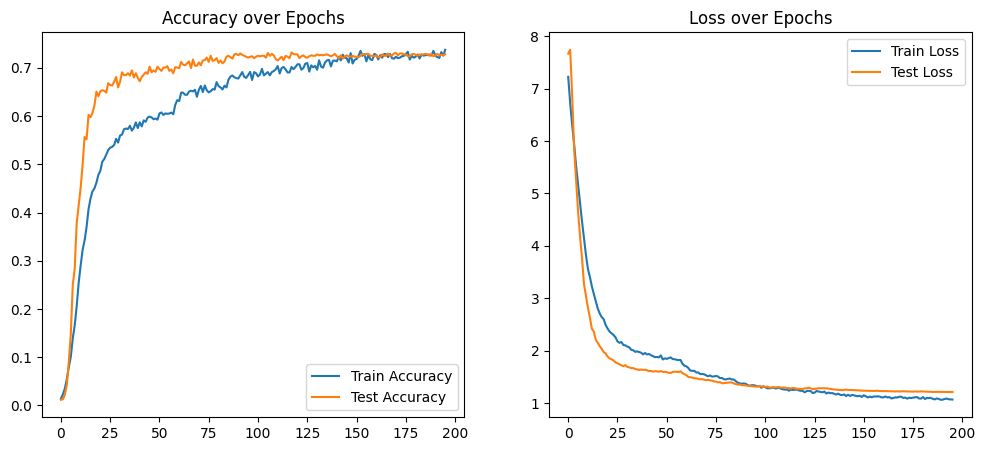

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.title("Loss over Epochs")

plt.show()

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
from collections import Counter
import cv2
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.applications import VGG16, imagenet_utils
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

Classes: ['Adho Mukha Svanasana', 'Adho Mukha Vrksasana', 'Alanasana', 'Anjaneyasana', 'Ardha Chandrasana', 'Ardha Matsyendrasana', 'Ardha Navasana', 'Ardha Pincha Mayurasana', 'Ashta Chandrasana', 'Baddha Konasana', 'Bakasana', 'Balasana', 'Bitilasana', 'Camatkarasana', 'Dhanurasana', 'Eka Pada Rajakapotasana', 'Garudasana', 'Halasana', 'Hanumanasana', 'Malasana', 'Marjaryasana', 'Navasana', 'Padmasana', 'Parsva Virabhadrasana', 'Parsvottanasana', 'Paschimottanasana', 'Phalakasana', 'Pincha Mayurasana', 'Salamba Bhujangasana', 'Salamba Sarvangasana', 'Setu Bandha Sarvangasana', 'Sivasana', 'Supta Kapotasana', 'Trikonasana', 'Upavistha Konasana', 'Urdhva Dhanurasana', 'Urdhva Mukha Svsnssana', 'Ustrasana', 'Utkatasana', 'Uttanasana', 'Utthita Hasta Padangusthasana', 'Utthita Parsvakonasana', 'Vasisthasana', 'Virabhadrasana One', 'Virabhadrasana Three', 'Virabhadrasana Two', 'Vrksasana'] 
No. of classes: 47


C:\Users\raksh\AppData\Local\Temp\ipykernel_12788\4021610408.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Class', data=label_counts_df, palette='cool')


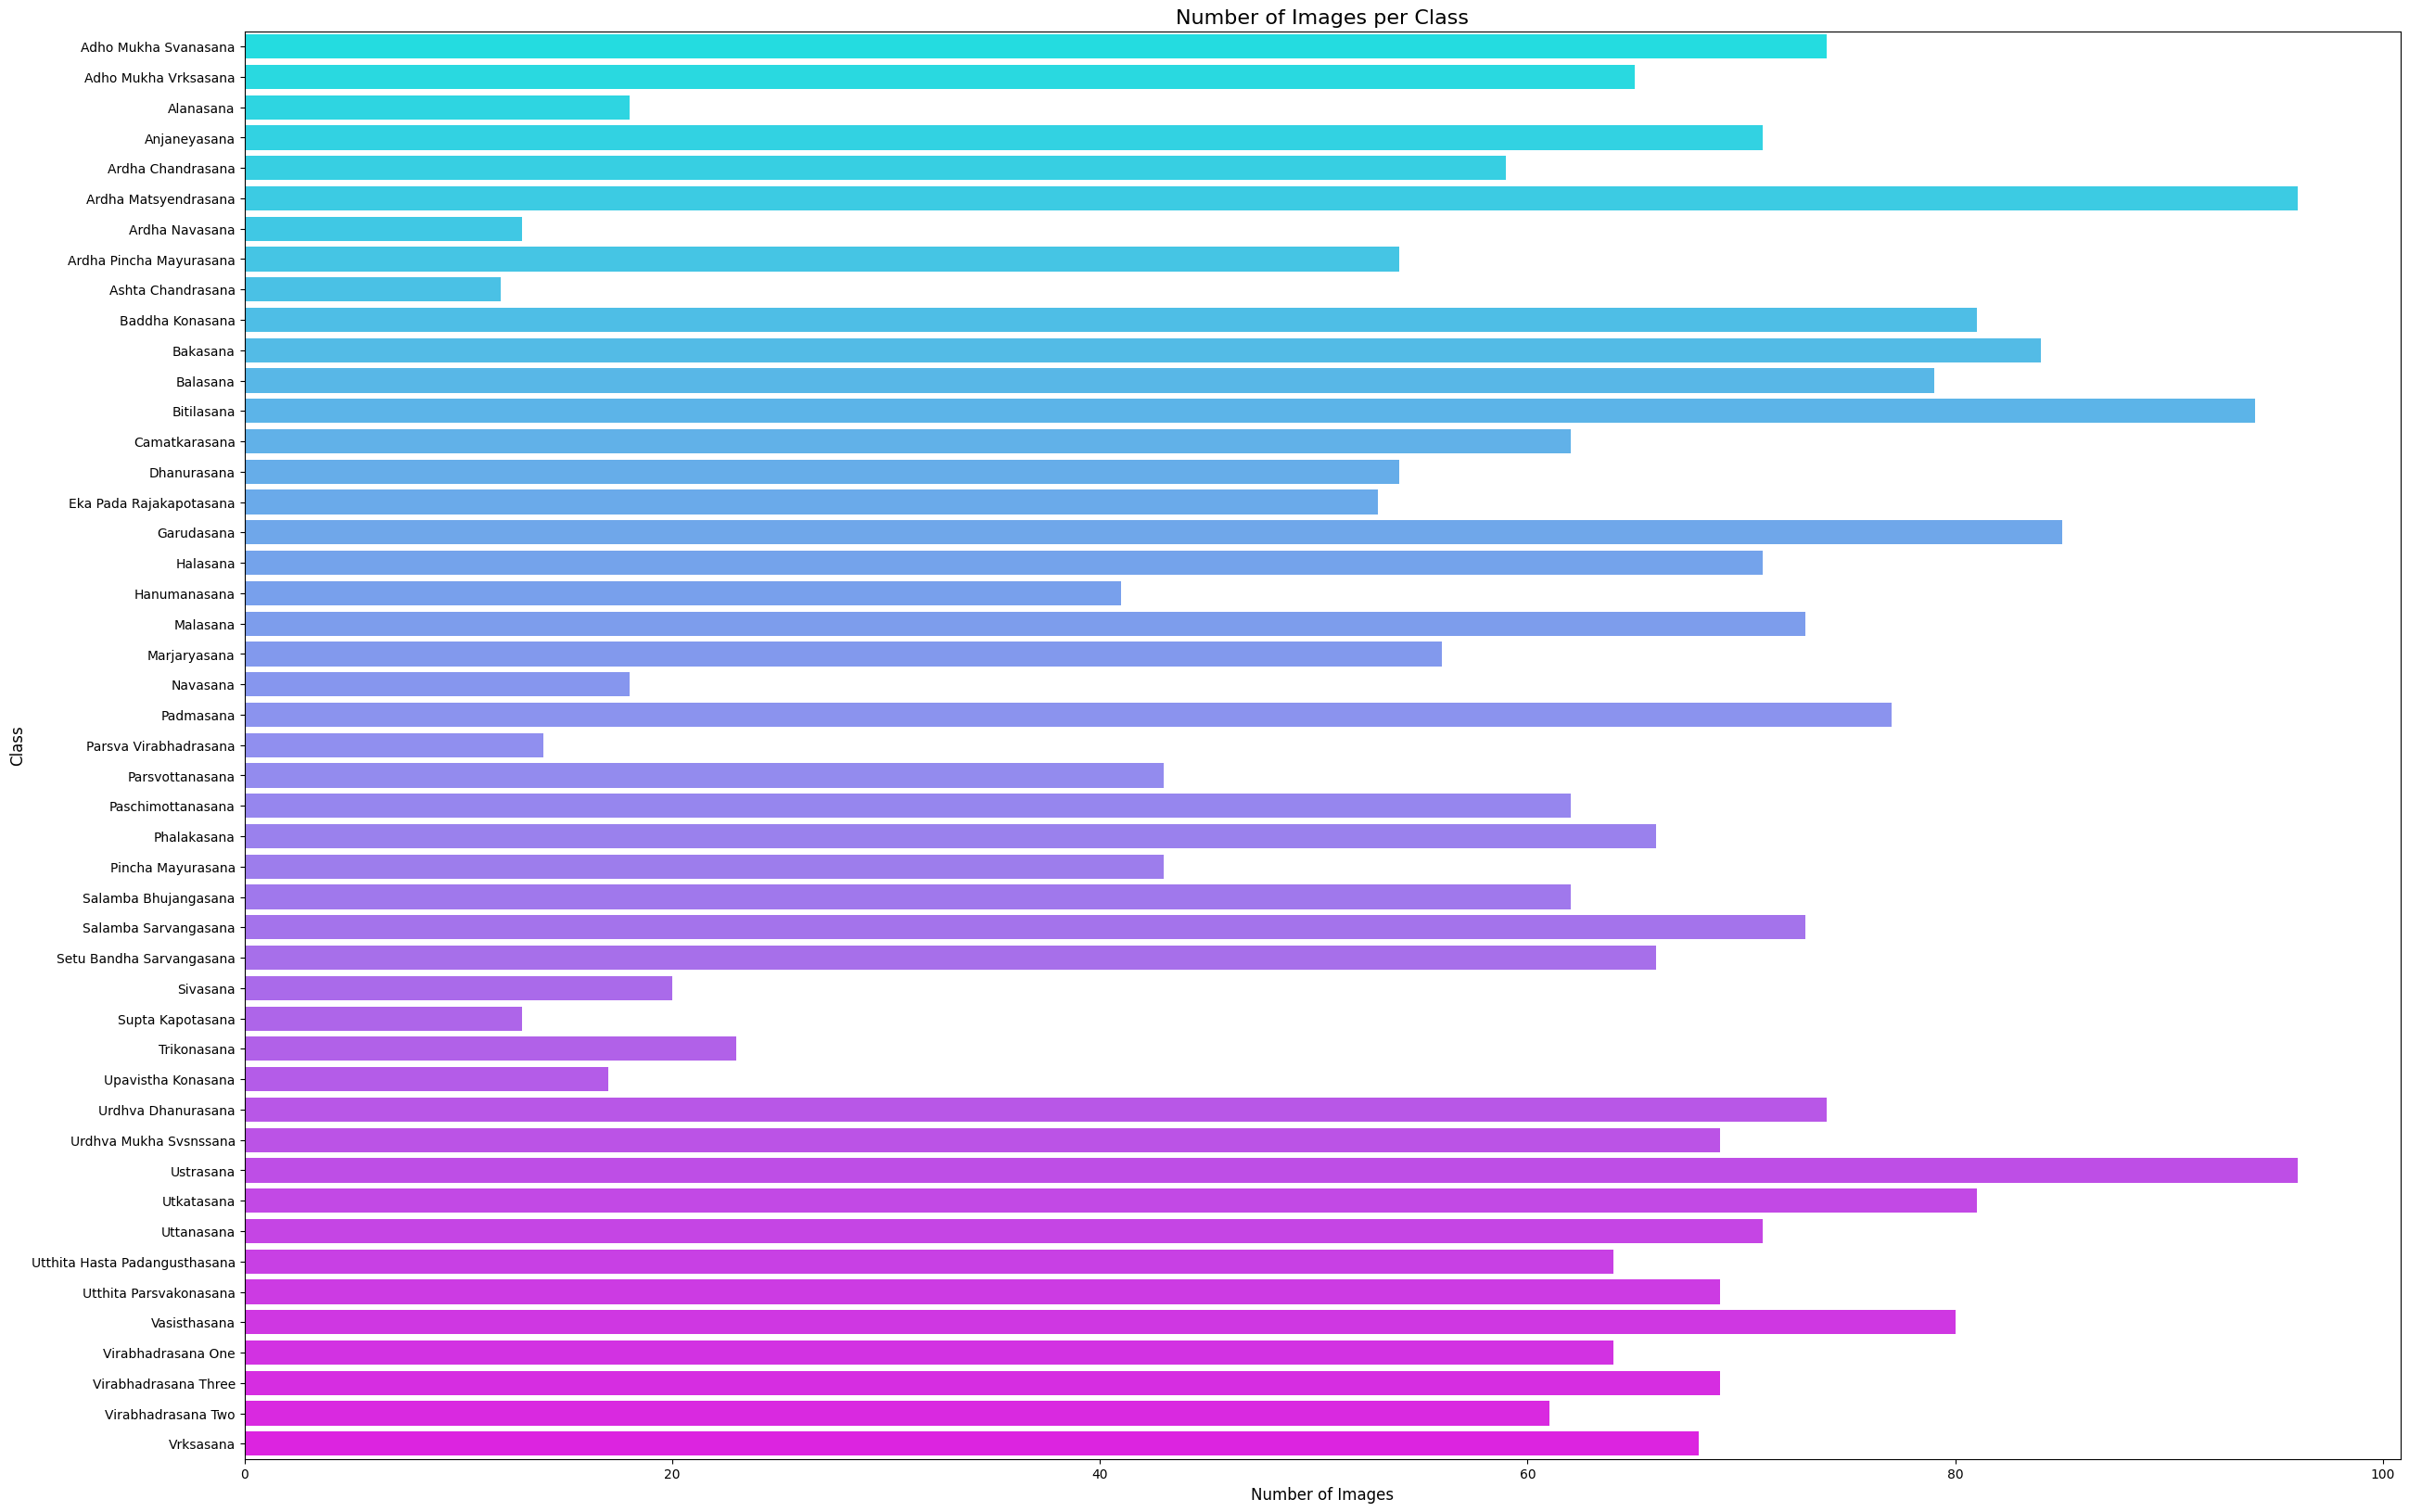

In [20]:
# Get the list of all subdirectories (classes)
dataset_path = "yoga-posture-dataset"
classes = os.listdir(dataset_path)
classes = [x for x in classes if x!='Poses.json']
print("Classes:", classes,'\nNo. of classes:',len(classes))
# Initialize an empty list to store labels
labels = []

# Loop through each class and get the number of images in each class
for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        num_images = len(os.listdir(class_dir))  # Count number of images in each class
        labels.extend([class_name] * num_images)  # Append the class label for each image

# Count the number of images per class
label_counts = Counter(labels)

# Convert the label counts into a DataFrame for seaborn

label_counts_df = pd.DataFrame(list(label_counts.items()), columns=['Class', 'Count'])

# Create the seaborn barplot
plt.figure(figsize=(30,20))
sns.barplot(x='Count', y='Class', data=label_counts_df, palette='cool')

# Add title and labels
plt.title('Number of Images per Class', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Class', fontsize=12)

# Show the plot
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


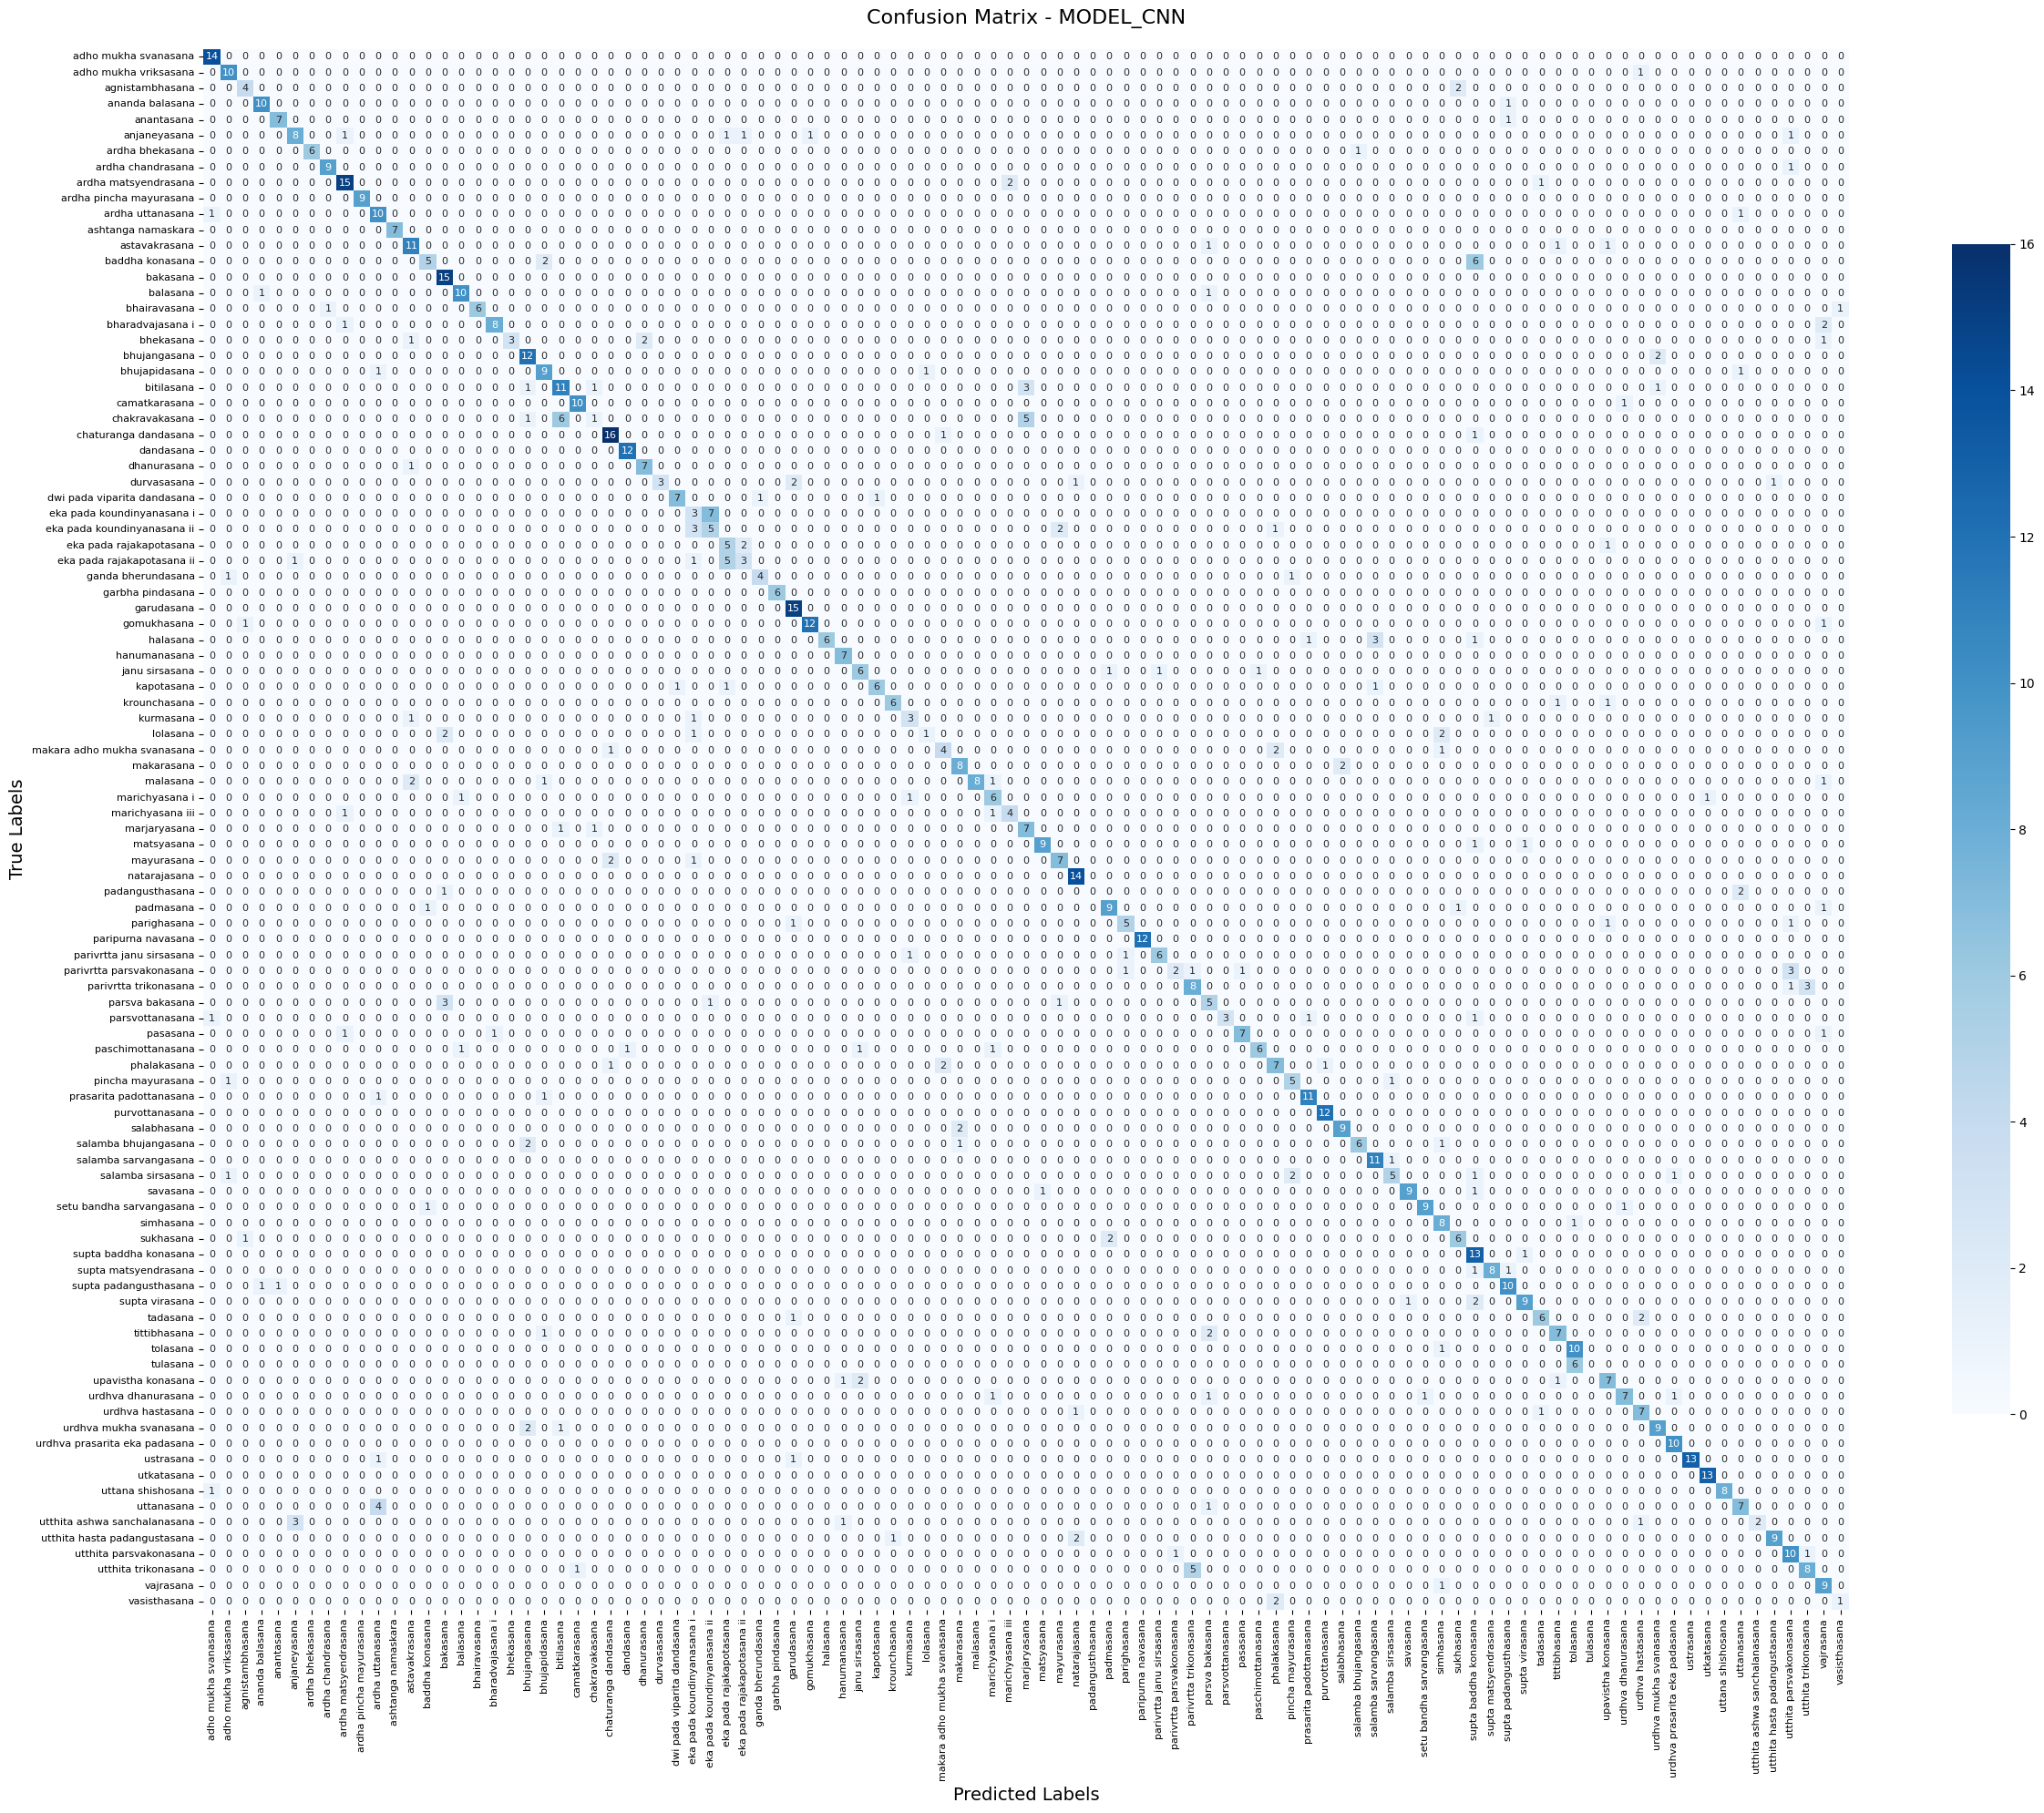

In [28]:
def plot_confusion_matrix(model_path, X_test, y_test, model_type='keras', class_names=None):
    """
    Generate enhanced confusion matrix plot for your trained models
    
    Args:
        model_path: Path to .h5 (Keras) or .pkl (Scikit-learn) model
        X_test: Test features
        y_test: True labels (one-hot encoded or class indices)
        model_type: 'keras' or 'sklearn'
        class_names: Array or list of class names in order
    """
    # Load model and make predictions
    if model_type == 'keras':
        model = load_model(model_path)
        y_pred = model.predict(X_test).argmax(axis=1)
    else:  # sklearn
        model = joblib.load(model_path)
        y_pred = model.predict(X_test)
    
    # Convert one-hot if needed
    if y_test.ndim > 1:
        y_test = y_test.argmax(axis=1)
    
    # Use numeric labels if class names not provided
    if class_names is None:
        class_names = sorted(set(y_test))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create figure with adjusted size
    plt.figure(figsize=(25, 20))
    
    # Enhanced heatmap
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size": 8},
        cbar_kws={"shrink": 0.75}
    )
    
    # Customize appearance
    model_name = os.path.basename(model_path).split('.')[0].upper()
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.xticks(
        rotation=90, 
        fontsize=8,
        horizontalalignment='center'
    )
    plt.yticks(
        rotation=0, 
        fontsize=8,
        verticalalignment='center'
    )
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
plot_confusion_matrix(
    'model_cnn.h5',
    X_test,
    y_test,
    model_type='keras',
    class_names=label_encoder.classes_  # Now passing the array directly
)


In [30]:
from sklearn.metrics import classification_report
import numpy as np

def print_model_report(model_path, X_test, y_test, class_names, model_type='keras'):
    """
    Print classification report for a saved model
    
    Args:
        model_path: Path to .h5 or .pkl file
        X_test: Test features
        y_test: True labels (one-hot or indices)
        class_names: List of class names in order
        model_type: 'keras' or 'sklearn'
    """
    # Load model and predict
    if model_type == 'keras':
        model = load_model(model_path)
        y_pred = model.predict(X_test).argmax(axis=1)
    else:
        model = joblib.load(model_path)
        y_pred = model.predict(X_test)
    
    # Convert one-hot if needed
    if y_test.ndim > 1:
        y_test = y_test.argmax(axis=1)
    
    # Generate and print report
    print(f"\n{'-'*50}")
    print(f"Classification Report for {os.path.basename(model_path)}")
    print(f"{'-'*50}")
    print(classification_report(
        y_test,
        y_pred,
        target_names=class_names,
        digits=4  # Show 4 decimal places
    ))
    print(f"{'-'*50}\n")

# Example usage:
class_names = label_encoder.classes_  # Your class names array

# For CNN (.h5)
print_model_report(
    'model_cnn.h5',
    X_test,
    y_test,
    class_names,
    model_type='keras'
)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

--------------------------------------------------
Classification Report for model_cnn.h5
--------------------------------------------------
                               precision    recall  f1-score   support

         adho mukha svanasana     0.8235    1.0000    0.9032        14
        adho mukha vriksasana     0.7692    0.9091    0.8333        11
              agnistambhasana     0.6667    0.6667    0.6667         6
              ananda balasana     0.8333    0.9091    0.8696        11
                   anantasana     0.8750    0.8750    0.8750         8
                 anjaneyasana     0.6667    0.6154    0.6400        13
              ardha bhekasana     1.0000    0.8571    0.9231         7
            ardha chandrasana     0.9000    0.9000    0.9000        10
         ardha matsyendrasana     0.7895    0.8333    0.8108        18
      ardha pincha mayurasana     1.0000    1.0000    1.0000         9
             ardha uttanasana     0.5

c:\Users\raksh\OneDrive\Desktop\Mv_Project\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\raksh\OneDrive\Desktop\Mv_Project\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\raksh\OneDrive\Desktop\Mv_Project\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.